In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts

from datetime import datetime, timedelta 

In [2]:
pip install pandas_datareader


Note: you may need to restart the kernel to use updated packages.


In [7]:
from pandas_datareader import data 

In [9]:
start = datetime(1985,1,1)
end = datetime(2019,12,31)



In [13]:
gdpdata = data.DataReader ('GDPC1', data_source = 'fred',start=start,end=end)

gdpdata.head(3)

,GDPC1
DATE,
1985-01-01,8400.820
1985-04-01,8474.787
1985-07-01,8604.220


In [21]:
gdpdata['gdpgr'] = gdpdata.GDPC1.pct_change()*100

gdpdata.head(3)

,GDPC1,gdpgr
DATE,,
1985-01-01,8400.820,NaN
1985-04-01,8474.787,0.880474
1985-07-01,8604.220,1.527271


In [25]:
ratedata = data.DataReader('TB3MS', data_source ='fred',start=start,end=end)
ratedata.head(3)

,TB3MS
DATE,
1985-01-01,7.76
1985-02-01,8.27
1985-03-01,8.52


In [27]:
rate_q = ratedata.resample('3ME').last() 
rate_q.head(3)

,TB3MS
DATE,
1985-01-31,7.76
1985-04-30,7.95
1985-07-31,7.08


In [40]:
gdpdata.index = gdpdata.index.to_period('M').to_timestamp('M')



In [42]:
df = gdpdata
df['rate'] = rate_q['TB3MS']
df.head(3)

,GDPC1,gdpgr,rate
DATE,,,
1985-01-31,8400.820,NaN,7.76
1985-04-30,8474.787,0.880474,7.95
1985-07-31,8604.220,1.527271,7.08


<Axes: xlabel='DATE'>

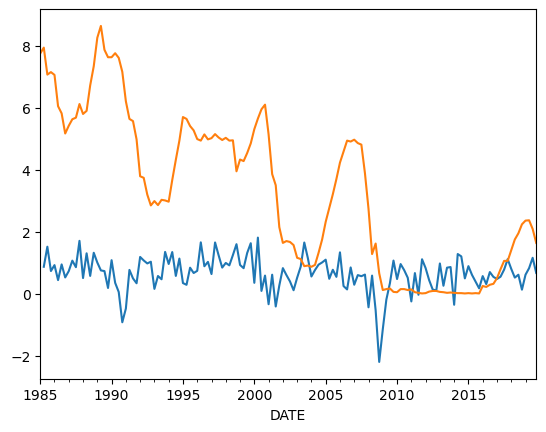

In [48]:
df.gdpgr.plot()
df.rate.plot()

In [68]:
df['drate'] = df.rate.diff()


<Axes: xlabel='DATE'>

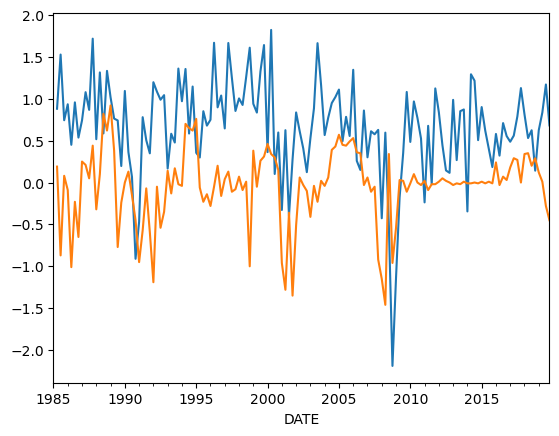

In [116]:
df['drate']=df.rate.diff()
df.head()
df.gdpgr.plot()
df.drate.plot()

In [56]:
sts.adfuller(df.gdpgr[1:])

(-5.271434863129547,
 6.273149846544645e-06,
 1,
 137,
 {'1%': -3.479007355368944,
  '5%': -2.8828782366015093,
  '10%': -2.5781488587564603},
 195.9371852588353)

In [60]:
sts.adfuller(df.drate[1:])

(-5.031559846551169,
 1.9213182942815076e-05,
 1,
 137,
 {'1%': -3.479007355368944,
  '5%': -2.8828782366015093,
  '10%': -2.5781488587564603},
 106.02672840472405)

In [62]:
from statsmodels.tsa.api import VAR

In [74]:
vardf = df[['gdpgr','drate']][1:]

vardf.head(3)

,gdpgr,drate
DATE,,
1985-04-30,0.880474,0.19
1985-07-31,1.527271,-0.87
1985-10-31,0.743449,0.08


In [78]:
model = VAR(vardf)
results = model.fit(maxlags =3)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 17, Mar, 2025
Time:                     16:47:40
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -2.94376
Nobs:                     136.000    HQIC:                  -3.12175
Log likelihood:          -151.387    FPE:                  0.0390306
AIC:                     -3.24359    Det(Omega_mle):       0.0353030
--------------------------------------------------------------------
Results for equation gdpgr
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            0.371112         0.090473            4.102           0.000
L1.gdpgr         0.292421         0.088436            3.307           0.001
L1.drate        -0.081661         0.127390           -0.641           0.521
L2.g

In [82]:
model_comp = model.select_order(maxlags =12)
model_comp.summary()

,AIC,BIC,FPE,HQIC
0,-2.833,-2.788,0.05884,-2.815
1,-3.298,-3.163*,0.03697,-3.243*
2,-3.332*,-3.108,0.03573*,-3.241
3,-3.282,-2.968,0.03757,-3.154
4,-3.256,-2.852,0.03858,-3.092
5,-3.201,-2.708,0.04075,-3.001
6,-3.234,-2.652,0.03945,-2.997
7,-3.197,-2.525,0.04098,-2.924
8,-3.158,-2.396,0.04267,-2.848
9,-3.169,-2.318,0.04225,-2.823


<Axes: xlabel='DATE'>

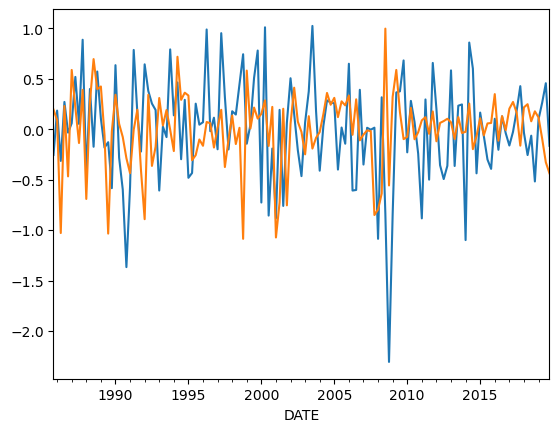

In [86]:
model = VAR(vardf)
results = model.fit(maxlags =2)
results.resid.gdpgr.plot()
results.resid.drate.plot()

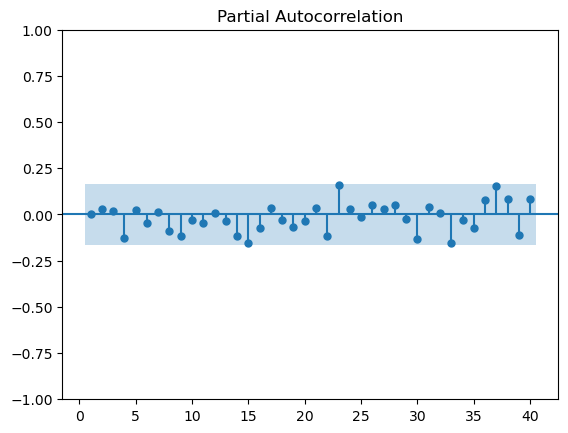

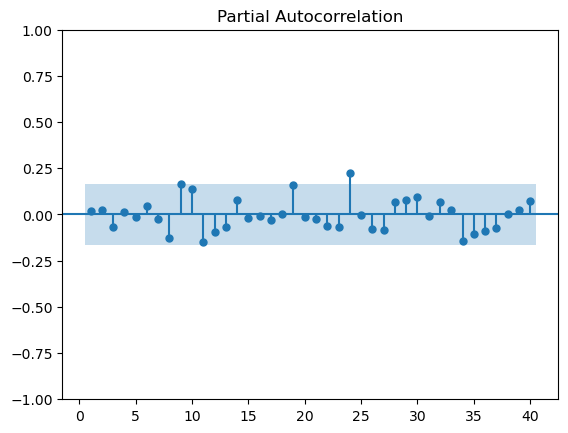

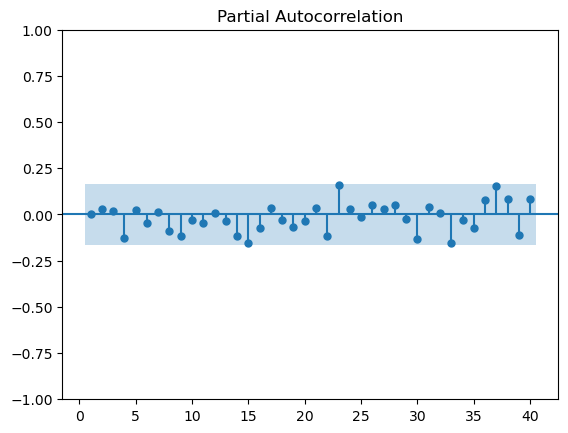

In [92]:
sgt.plot_pacf(results.resid.gdpgr,lags =40 , zero=False)
sgt.plot_pacf(results.resid.drate, lags =40, zero =False)

In [94]:
train  = vardf[:-4]
test = vardf[-4:]

model = VAR(train)
lags =2
results = model.fit(maxlags =lags)

In [96]:
fcinput = train.values[-1*lags:]

In [98]:
fc = results.forecast(y=fcinput,steps =4)
fc

array([[ 0.51556479,  0.00163983],
       [ 0.53502552,  0.04342887],
       [ 0.58502082, -0.01585835],
       [ 0.61075482, -0.01892778]])

In [100]:
df_fc = pd.DataFrame(fc, index = test.index, columns = test.columns)
df_fc

,gdpgr,drate
DATE,,
2019-01-31,0.515565,0.001640
2019-04-30,0.535026,0.043429
2019-07-31,0.585021,-0.015858
2019-10-31,0.610755,-0.018928


In [110]:
train['rate']=df.rate[:-4]
test['rate']=df.rate[-4:]
df_fc['rate']=train.rate.iloc[-1] + df_fc.drate.cumsum()

C:\Users\wilfo\AppData\Local\Temp\ipykernel_13728\1310682778.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['rate']=df.rate[:-4]
C:\Users\wilfo\AppData\Local\Temp\ipykernel_13728\1310682778.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['rate']=df.rate[-4:]


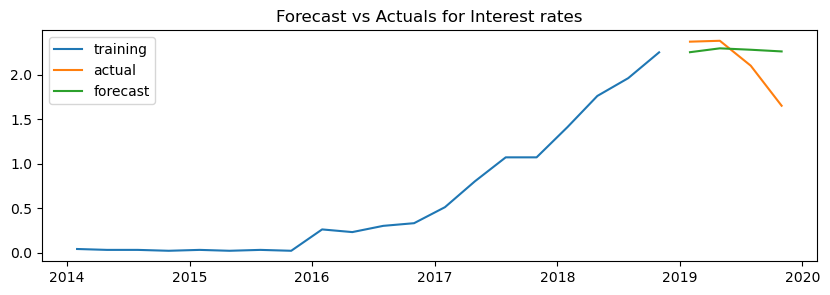

In [114]:
plt.figure(figsize=(10,3))
plt.plot(train.rate[-20:], label='training')
plt.plot(test.rate, label='actual')
plt.plot(df_fc.rate, label='forecast')
plt.title('Forecast vs Actuals for Interest rates')
plt.legend(loc='upper left')